In [110]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import array

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from scipy.optimize import curve_fit

In [111]:
# Read csv of Education distribution
# Remove all the entries that don't have "County"
df = pd.read_csv('Education_data_compiled.csv')
df = df[df['Area name'].str.contains('County')]
df = df.sort_values(by=['State','Area name'],ignore_index=True)

In [112]:
# Add columns of Unemployment and Median HH Income
new_df = pd.read_csv('Unemployed_data_compiled.csv')
new_df = new_df[new_df['Area name'].str.contains('County')]
new_df.sort_values(by=['Area name'],ignore_index=True)

# For this file, area name stick with state => split it
def f(x,delm=','):
    return x.split(delm)[0], x.split(delm)[1][1:]

new_df['State'] = new_df['Area name'].map(lambda x: f(x)[1])
new_df['Area name'] = new_df['Area name'].map(lambda x: f(x)[0])

new_df = new_df.sort_values(by=['State','Area name'],ignore_index=True)
result = pd.merge(df,new_df,how='inner', on=['Area name','State'])
df = result.rename(columns={"Area name": "County", "Unemployment_rate_2019": "Percent of unemployment 2019", 
                       "Median_Household_Income_2018": "Median Household Income 2018"})

In [113]:
# Add data of covid case
COVID_counties_df=pd.read_csv('us_counties_covid19_daily.csv')
del COVID_counties_df['fips']
COVID_baltimore_df=COVID_counties_df[COVID_counties_df['county']=='Baltimore']

In [124]:
# Run the prediction
# univariate lstm example

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [125]:
# Perform prediction 
def single_pred(x_input, n_steps, n_features):
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    return yhat

In [126]:
def make_prediction(cases_train, n_steps, num_pred):
    yhat_array = np.zeros(num_pred)
    for i in range(num_pred):
        if i < len(cases_train)-n_steps:
            x_input = cases_train[i:i+n_steps]
            yhat = single_pred(x_input, n_steps, n_features)
            yhat_array[i] = yhat
        else:
            x_input = np.append(x_input[1:n_steps],yhat) # create feature from previous prediction
            yhat = single_pred(x_input, n_steps, n_features)
            yhat_array[i] = yhat
    return yhat_array

In [134]:
# Data:
cases = np.array(COVID_baltimore_df['cases'])
# Split data to train the model: 70:30
test_train_split = 0.7
cases_train = cases[0:int(len(cases)*test_train_split)]
cases_test = cases[int(len(cases)*test_train_split):]

In [139]:
# Perform prediction:

# choose a number of time steps (how many days to use for prediction)
n_steps = 3

# split into samples
X, y = split_sequence(cases_train, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X, y, epochs=200, verbose=0)

yhat_array = make_prediction(cases_train, n_steps, len(cases)-n_steps)
#print(yhat_array)

## Plotting the predicted cases vs. observed cases

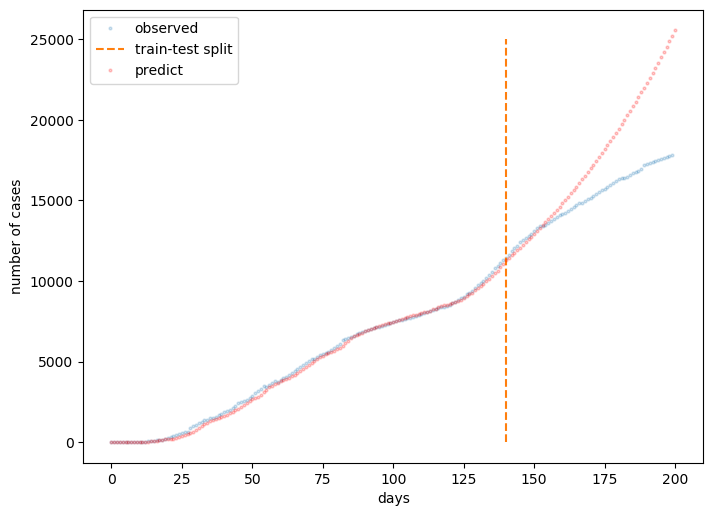

In [136]:
fig,ax = plt.subplots(figsize=(8,6),dpi=100)
ax.plot(cases,'o',markersize=2,alpha=0.2,label='observed')
#ax.plot(np.append(cases_train,yhat_array),'or',markersize=2,alpha=0.2,label='predict')
ax.plot([int(len(cases)*test_train_split),int(len(cases)*test_train_split)],[0,25000],'--',label='train-test split')
ax.plot(np.append(cases[0:n_steps+1],yhat_array),'or',markersize=2,alpha=0.2,label='predict')
ax.set_xlabel('days')
ax.set_ylabel('number of cases')
ax.legend()

# Fitting the predicted cases to a polynomial regression model

y = 0.00005 * x^4 + -0.01480 * x^3 + 1.67476 * x^2 + 8.96732 * x + -346.02531


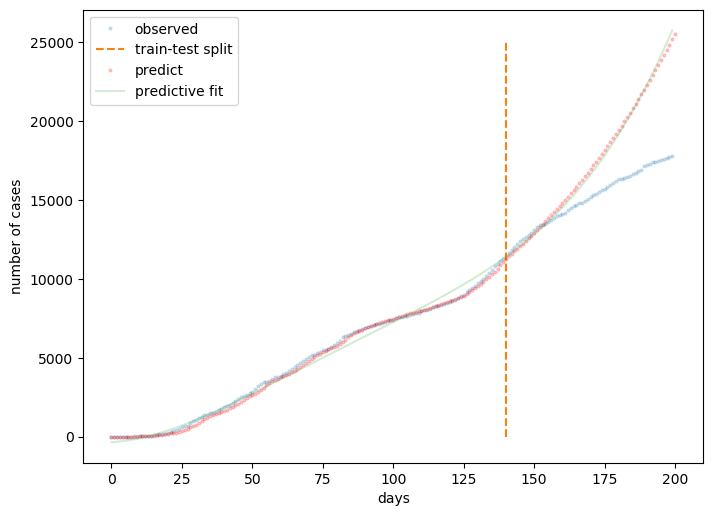

In [138]:
def get_fit_parameters(cases, yhat_array, n_steps):
    def objective(x, a, b, c, d, e):
        return a * x**4 + b * x**3 + c * x**2 + d * x + e
    y = np.append(cases[0:n_steps+1],yhat_array)
    num_of_values = len(y)
    x = np.linspace(0,num_of_values-1,num_of_values)
    popt, _ = curve_fit(objective, x, y)
    a, b, c, d, e = popt
    return a, b, c, d, e

a, b, c, d, e = get_fit_parameters(cases,yhat_array,n_steps)
print('y = %.5f * x^4 + %.5f * x^3 + %.5f * x^2 + %.5f * x + %.5f' % (a, b, c, d, e))
y_fit = a*x**4 + b*x**3 + c*x**2 + d*x + e
fig,ax = plt.subplots(figsize=(8,6),dpi=100)
ax.plot(cases,'o',markersize=2,alpha=0.2,label='observed')
#ax.plot(np.append(cases_train,yhat_array),'or',markersize=2,alpha=0.2,label='predict')
ax.plot([int(len(cases)*test_train_split),int(len(cases)*test_train_split)],[0,25000],'--',label='train-test split')
ax.plot(np.append(cases[0:n_steps+1],yhat_array),'or',markersize=2,alpha=0.2,label='predict')
ax.set_xlabel('days')
ax.set_ylabel('number of cases')
ax.plot(y_fit,markersize=2,alpha=0.2,label='predictive fit')
ax.legend()

## Single function to acquire regression parameters for a predicted covid function

In [140]:
def predict_case_fun_parameters(cases,n_steps,test_train_split):
    cases_train = cases[0:int(len(cases)*test_train_split)]
    cases_test = cases[int(len(cases)*test_train_split):]
    # Perform prediction:
    
    # split into samples
    X, y = split_sequence(cases_train, n_steps)
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))

    # define model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # fit model
    model.fit(X, y, epochs=200, verbose=0)

    yhat_array = make_prediction(cases_train, n_steps, len(cases)-n_steps)
    #print(yhat_array)
    
    a, b, c, d, e = get_fit_parameters(cases,yhat_array,n_steps)
    return a,b,c,d,e

In [142]:
a, b, c, d, e = predict_case_fun_parameters(cases,n_steps,test_train_split)
print('y = %.5f * x^4 + %.5f * x^3 + %.5f * x^2 + %.5f * x + %.5f' % (a, b, c, d, e))

y = 0.00004 * x^4 + -0.01365 * x^3 + 1.58237 * x^2 + 11.32631 * x + -353.30746
